In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/thesis/models')

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import string
from tensorflow.keras import layers
from utility import process_md_lines

In [4]:
training_lines = open('/content/drive/MyDrive/thesis/models/dataset_splits/training.txt','r',encoding='utf-8').readlines()
testing_lines = open('/content/drive/MyDrive/thesis/models/dataset_splits/testing.txt','r',encoding='utf-8').readlines()
validation_lines = open('/content/drive/MyDrive/thesis/models/dataset_splits/validation.txt','r',encoding='utf-8').readlines()

In [5]:
training_df = process_md_lines(training_lines)
testing_df = process_md_lines(testing_lines)
validation_df = process_md_lines(validation_lines)

In [6]:
training_df.head()

,id,text,order,total_lines,url,label
0,290,الشريان الأبهر هو أكبر شريان في الجسم وهو ينقل...,0,89,https://www.mayoclinic.org/ar/diseases-conditi...,Overview
1,290,بشكل عام يكون تضيق الأبهر موجودا لدى المصاب من...,1,89,https://www.mayoclinic.org/ar/diseases-conditi...,Overview
2,290,وغالبا ما يصاحب تضيق الأبهر عيوب أخرى في القلب...,2,89,https://www.mayoclinic.org/ar/diseases-conditi...,Overview
3,290,تعتمد أعراض تضيق الأبهر على شدة الحالة فمعظم ا...,3,89,https://www.mayoclinic.org/ar/diseases-conditi...,Symptoms
4,290,قد يبدأ ظهور الأعراض على الأطفال المصابين بتضي...,4,89,https://www.mayoclinic.org/ar/diseases-conditi...,Symptoms


In [7]:
tclasses = training_df['label'].unique()
no_classes = len(tclasses)
no_classes

5

In [8]:
''' df = df.sample(frac=1.0, random_state=101)
cut_off = int(len(df)*0.7) '''
train_df = training_df
test_df = testing_df

In [9]:
X_train = train_df['text'].to_numpy()
X_test = test_df['text'].to_numpy()

In [10]:
y_train = pd.get_dummies(train_df['label']).to_numpy()
y_test = pd.get_dummies(test_df['label']).to_numpy()

In [109]:
y_train

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]], dtype=uint8)

In [12]:
vocab = set()
for text in train_df['text'].to_numpy():
    tokens = text.split()
    vocab.update(tokens)

for text in test_df['text'].to_numpy():
    tokens = text.split()
    vocab.update(tokens)

In [13]:
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

69150

In [14]:
tokens_lens = [len(sentence.split()) for sentence in train_df['text'].to_numpy()]
SEQ_LENGTH = int(np.percentile(tokens_lens, 95))
SEQ_LENGTH

49

In [15]:
BATCH_SIZE = 32
WORD_EMBED_SIZE = 128

In [16]:
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=SEQ_LENGTH)

In [17]:
text_vectorizer.adapt(train_df['text'].to_numpy())

In [18]:
len(train_df['text'][0].split())


33

In [19]:
text_vectorizer(train_df['text'][0])

<tf.Tensor: shape=(49,), dtype=int64, numpy=
array([  295,  1015,    53,   300,  3271,     2,    54,   191,  4029,
          13, 13810,  1523,     3,   770,     6,  4231,    54, 16018,
         657,   295,  1015,   657,  1015,   770,     5,  6165,  2776,
         300,  6309,    13,   163,   295,  1015,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0])>

In [20]:
embedding = tf.keras.layers.Embedding(
    VOCAB_SIZE,
    WORD_EMBED_SIZE,
    mask_zero=True
)

In [21]:
model = tf.keras.models.Sequential([
    layers.Input(shape=[], dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.Conv1D(128, kernel_size=5, padding="same", activation="relu"),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(no_classes, activation='softmax')
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 49)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 49, 128)           8851200   
                                                                 
 conv1d (Conv1D)             (None, 49, 128)           82048     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 64)                8

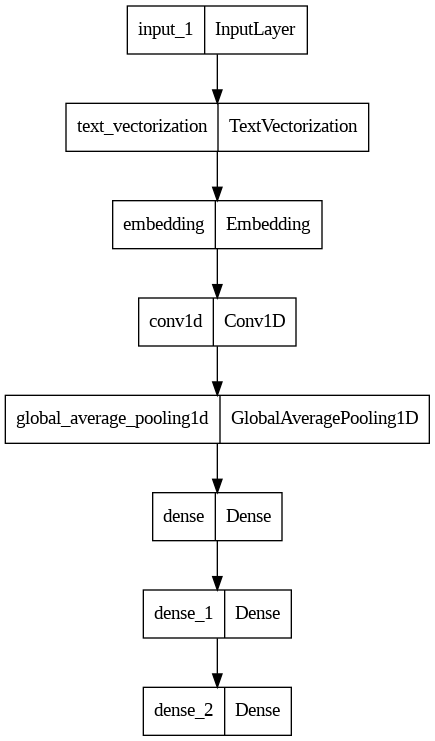

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [24]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [25]:
model.compile(loss="categorical_crossentropy",optimizer='adam', metrics=['accuracy'])

In [26]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=2,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False)

In [27]:
model.fit(train_ds, validation_data=test_ds, epochs=10, callbacks=[es])

Epoch 1/10
9273/9273 [==============================] - 94s 9ms/step - loss: 0.5549 - accuracy: 0.8137 - val_loss: 0.3594 - val_accuracy: 0.8853
Epoch 2/10
9273/9273 [==============================] - 86s 9ms/step - loss: 0.2558 - accuracy: 0.9193 - val_loss: 0.2462 - val_accuracy: 0.9266
Epoch 3/10
9273/9273 [==============================] - 84s 9ms/step - loss: 0.1538 - accuracy: 0.9521 - val_loss: 0.2031 - val_accuracy: 0.9468
Epoch 4/10
9273/9273 [==============================] - 86s 9ms/step - loss: 0.1080 - accuracy: 0.9658 - val_loss: 0.1693 - val_accuracy: 0.9579
Epoch 5/10
9273/9273 [==============================] - 86s 9ms/step - loss: 0.0854 - accuracy: 0.9724 - val_loss: 0.1673 - val_accuracy: 0.9630
Epoch 6/10
9273/9273 [==============================] - 87s 9ms/step - loss: 0.0714 - accuracy: 0.9765 - val_loss: 0.2018 - val_accuracy: 0.9601
Epoch 7/10
9273/9273 [==============================] - 84s 9ms/step - loss: 0.0630 - accuracy: 0.9787 - val_loss: 0.1594 - val_ac

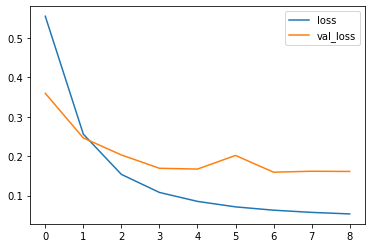

In [28]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()

In [29]:
model.evaluate(test_ds)

1142/1142 [==============================] - 5s 4ms/step - loss: 0.1613 - accuracy: 0.9710


[0.16126133501529694, 0.9709771871566772]

In [93]:
preds = np.argmax(model.predict(X_test), axis=1)


1142/1142 [==============================] - 3s 2ms/step


In [111]:
preds

array([2, 1, 3, ..., 4, 4, 4])

In [116]:
cat_preds = tf.keras.utils.to_categorical(preds,dtype='int') #convert categorical to sparse 
cat_preds

array([[0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

In [117]:
y_test

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]], dtype=uint8)

In [118]:
from sklearn.metrics import classification_report
print(classification_report(y_test, cat_preds))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      6114
           1       0.99      0.98      0.98      6152
           2       0.97      0.96      0.96      3572
           3       0.94      0.98      0.96      7663
           4       0.99      0.98      0.98     13022

   micro avg       0.97      0.97      0.97     36523
   macro avg       0.97      0.97      0.97     36523
weighted avg       0.97      0.97      0.97     36523
 samples avg       0.97      0.97      0.97     36523



In [47]:
r = np.random.randint(0,len(X_train))
text = X_train[r]
true_pred = y_train[r]
print(text)
print(true_pred)

على الرغم من عدم وجود علاج شاف لكثرة الصفيحات الأساسية لكن يمكن أن تتحكم العلاجات في الأعراض وتقليل خطر حدوث المضاعفات حيث من المتوقع أن تكون فترة الحياة طبيعية على الرغم من المرض

[0 0 0 0 1]


In [48]:
myTensor = tf.convert_to_tensor(text, dtype=tf.string) 
myTensor = tf.expand_dims(myTensor,axis=-1)
class_index = np.argmax(model(myTensor))
class_index

4

In [49]:
train_df['label'][r]

'Treatment'